# Simple Siamese network

## Asembling dataset (mnist)

In [2]:
import pandas as pd
import os
import numpy as np
import csv
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


mnist_path= "../resources/mnist.csv"

In [3]:
NUMBER_OF_IMAGES_TO_READ_FROM_CSV=int(.8 * 60000)
NUMBER_OF_POS_PAIRS=4000
NUMBER_OF_NEG_PAIRS=4000


# code
print(f"Reading {NUMBER_OF_IMAGES_TO_READ_FROM_CSV} images from csv...\n")

label_image=[ 
    # {'label': 3, 'img':np.array(28x28) }
]
with open(mnist_path, "r") as csv_file:
    reader = csv.reader(csv_file)
    for i in range(NUMBER_OF_IMAGES_TO_READ_FROM_CSV):
        row = next(reader)
        # print(len(row),row,end="\n\n")

        label= int(row[0])
        image= np.array( [int(p) for p in row[1:] ] ).reshape((28,28))
        
        label_image.append({
            'label':label,
            'image':image
        })


#So after previous cell we have label_image which is a list of dicts:
# ```
# [
#     { 'label': 3, 'img': np.array(28x28)},
#     { 'label': 1, 'img': np.array(28x28)}
# ...
# ]
# ```
# Now we gotta create pairs out of that

# variable holding dataset called **img_img_label** is breated here

img_img_label=[
    # [np.array(), np.array(), 1]
]

log=False
elements_used=0

for label in [0,1,2,3,4,5,6,7,8,9]:
    if log: print(f"Creating pairs for label {label}")
    n_positive_pairs=0
    n_negative_pairs=0

    img_A=None
    get_first_img=True
    pos_neg=None
    for i, lbl_img in enumerate(label_image):

        if i>elements_used:
            elements_used=i

        if lbl_img['label'] == label:  # if label positive
            if get_first_img:
                if log: print(f"\tFound first img_A")
                img_A= lbl_img['image']
                get_first_img=False
            
            elif n_positive_pairs < NUMBER_OF_POS_PAIRS :
                if log: print(f"\tFound positive img_B", end="  ")
                if img_A is not None:
                    if log: print(f"adding")
                    n_positive_pairs+=1
                    img_img_label.append(
                        [img_A, lbl_img['image'], 1]
                    )
                else:
                    if log: print(f"skipping (no img_A yet)")
               
        
        elif n_negative_pairs < NUMBER_OF_NEG_PAIRS :
            if log: print(f"\tFound negative img_B", end="  ")
            if img_A is not None:
                    if log: print(f"adding")
                    n_negative_pairs+=1
                    img_img_label.append(
                        [img_A, lbl_img['image'], 0]
                    )
            else:
                if log: print(f"skipping (no img_A yet)")
       
        if n_negative_pairs>=NUMBER_OF_POS_PAIRS and n_positive_pairs>= NUMBER_OF_NEG_PAIRS:
            break
    
            
if len(img_img_label) == 10*(NUMBER_OF_POS_PAIRS + NUMBER_OF_NEG_PAIRS):
    print(f"Sucess: {len(img_img_label)} pairs created. Used {100*elements_used/NUMBER_OF_IMAGES_TO_READ_FROM_CSV:.0f}%")
else:
    print(f"Fail: {len(img_img_label)} pairs build of of {10*(NUMBER_OF_POS_PAIRS + NUMBER_OF_NEG_PAIRS)} required. \nSome pairs missing. Try reading more rows from csv file\n Used {100*elements_used/NUMBER_OF_IMAGES_TO_READ_FROM_CSV}")

del label_image, log, elements_used

Reading 48000 images from csv...

Sucess: 80000 pairs created. Used 93%


---
After running previous cell we have list called **img_img_label**  
It is a list of lists, structured as follows:  
```
[
    [img_A, img_B, label],
    [img_A, img_B, label],
    [img_A, img_B, label],
    ...
]

```
where:  
- `img_A` is a numpy array containing first  image (grayscale, shape (28x28))  
- `img_B` is a numpy array containing second image (grayscale, shape (28x28))  
- `label` is an integer, is equal to 0 if images contain diffrent digits, is equal to 1 if images are the same  

### Show image pairs

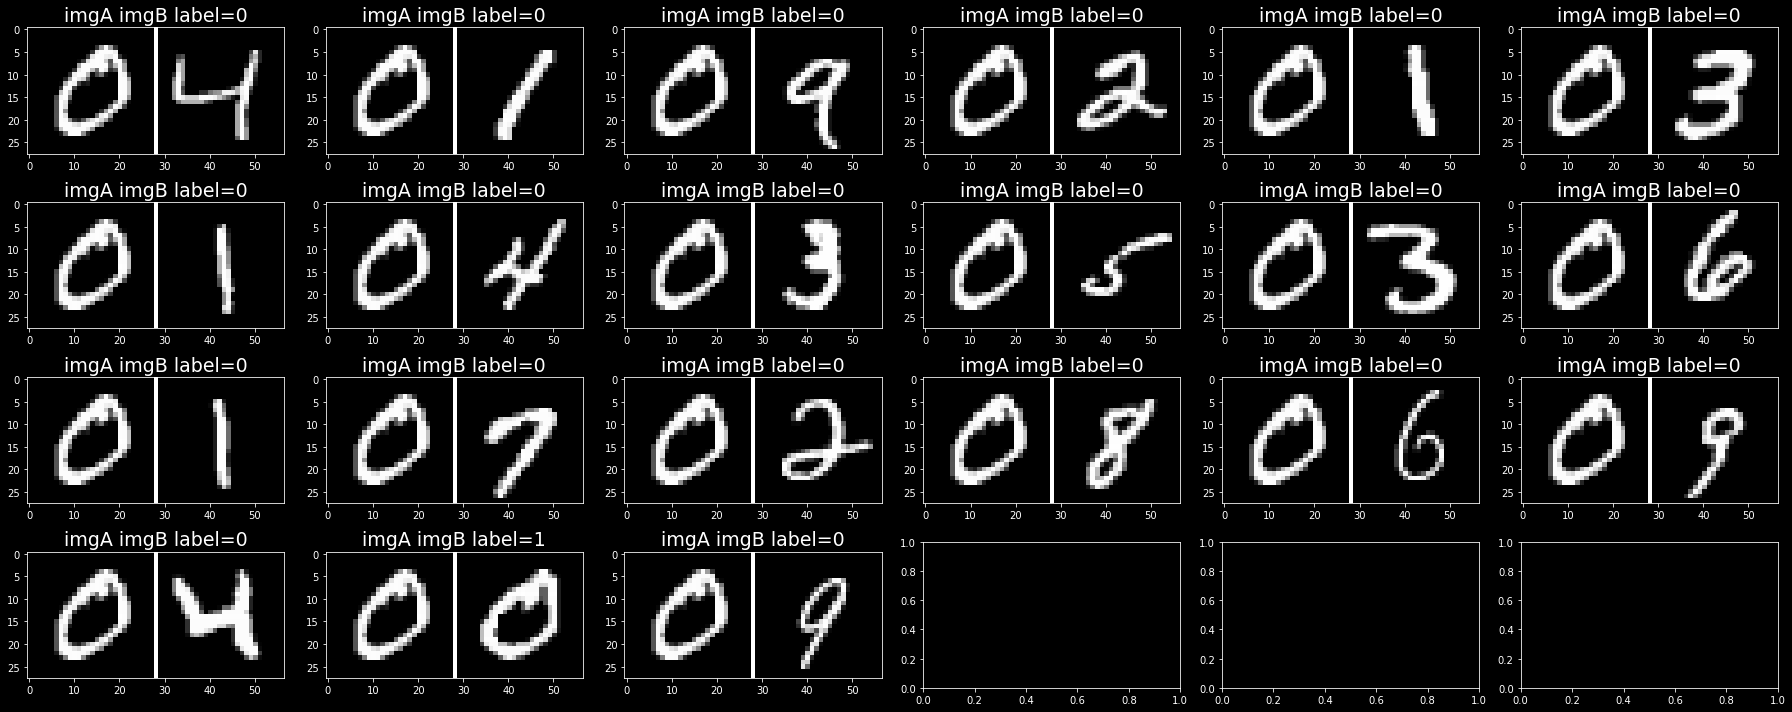

In [4]:
SHOW_FIRST_N_PAIRS=20

cols= 6
rows= 1+ SHOW_FIRST_N_PAIRS//cols
plt.style.use('dark_background')

fig= plt.figure(figsize=(25,10))
axes=fig.subplots(rows,cols).ravel()
i=0
for imgA, imgB, label in img_img_label:
    mashed_imgAB=  np.concatenate((imgA,255*np.ones((28,1)),imgB), axis=1)
    axes[i].imshow(mashed_imgAB, cmap='gray')
    axes[i].set_title(f"imgA imgB label={label}", fontsize=19)
    i+=1
    if i > SHOW_FIRST_N_PAIRS: break
fig.tight_layout()


Now we have a list of lists with data where:
```
[
    [np.array(28x28), np.array(28x28), 1],
    [np.array(28x28), np.array(28x28), 0],
]

```
## Building data generator for SNN

In [5]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, list_imgA_imgB_label, batch_size= 1, shuffle=False) -> None:
        """Creates generator.

        Args:
            list_imgA_imgB_label (list): list of lists where each dublist is [imgA, imgB, label] 
            shuffle (_type_): if True than shuffeling data after epoch.
            batch_size (int, optional): Size of batch. Defaults to 1.
        """

        self.data                   = list_imgA_imgB_label
        self.batch_size             = batch_size
        self.shuffle                = shuffle
        self.indices                = np.arange(len(self.data))
        self.on_epoch_end()

    def __len__(self):
        """Returns number of batches in the dataset.

        Returns:
            int: _description_
        """
        return len(self.data) // self.batch_size

    def __getitem__(self, index):
        """The __getitem__ method is called by TensorFlow to get a batch of training data for each iteration of training. It takes an index as input, which represents the index of the batch to return.

        Args:
            index (_type_): _description_

        Returns:
            _type_: _description_
        """
        batch_indices = self.indices[index * self.batch_size  :  (index + 1) * self.batch_size]
        batch_data = [self.data[idx] for idx in batch_indices] # list of [imgA, imgB, label]  i.e. [np.array(28x28), np.array(28x28), int]

        X1      = [sample[0] for sample in batch_data]
        X2      = [sample[1] for sample in batch_data]
        y_list  =  [sample[2] for sample in batch_data]

        X1 = np.array(X1).reshape(-1, 28, 28, 1)
        X2 = np.array(X2).reshape(-1, 28, 28, 1)
        Y  = np.array(y_list) 

        X1_tensor = tf.convert_to_tensor(X1, dtype=tf.float32)
        X2_tensor = tf.convert_to_tensor(X2, dtype=tf.float32)
        Y_tensor  = tf.convert_to_tensor(Y,  dtype=tf.float32)

        return [X1_tensor, X2_tensor], Y_tensor

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# Create train and validation generators
split_idx= int(0.9*len(img_img_label))
train_generator     = DataGenerator(img_img_label[:split_idx], batch_size=32, shuffle=True)
validation_generator= DataGenerator(img_img_label[split_idx:], batch_size=1000, )
print(f"{split_idx=}")
        

split_idx=72000


In [7]:
# TEst generator, get first batch
for batch in train_generator:
    print(f"{type(batch)=}")
    print(f"{len(batch)=}")
    print()
    print(f"\t{type(batch[0])=}")
    print(f"\t{len(batch[0])=}")
    print(f"\t\t{type(batch[0][0])=}")
    print(f"\t\t{batch[0][0].shape=}")
    print()
    print(f"\t\t{type(batch[0][1])=}")
    print(f"\t\t{batch[0][1].shape=}")

    print()
    print(f"{type(batch[1])=}")
    print(f"{batch[1].shape=}")
    break
    # print(f"Batch {i} inputs shape: {inputs.shape}")
    # print(f"Batch {i} targets shape: {targets.shape}")

type(batch)=<class 'tuple'>
len(batch)=2

	type(batch[0])=<class 'list'>
	len(batch[0])=2
		type(batch[0][0])=<class 'tensorflow.python.framework.ops.EagerTensor'>
		batch[0][0].shape=TensorShape([2, 28, 28, 1])

		type(batch[0][1])=<class 'tensorflow.python.framework.ops.EagerTensor'>
		batch[0][1].shape=TensorShape([2, 28, 28, 1])

type(batch[1])=<class 'tensorflow.python.framework.ops.EagerTensor'>
batch[1].shape=TensorShape([2])


### SNN architecture

In [6]:
def contrastive_loss(y_true, y_pred, margin=1.0):
    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))
    loss = tf.reduce_mean((1 - y_true) * square_pred + (y_true) * margin_square)
    return loss

In [7]:
def create_SSN_model(input_shape=(28, 28, 1)):

    # Create feature_extractor, (common part of SNN)
    input_layer = Input(shape=input_shape, name="input")

    x = Conv2D(128, (7, 7), activation='relu', name="conv1")(input_layer)
    x = MaxPooling2D((2, 2), name="max_pool1")(x)
    x = Conv2D(64, (3, 3), activation='relu', name="conv2")(x)
    # x = MaxPooling2D((2, 2), name="max_pool2")(x)
    x = Dropout(0.4, name="dropout1")(x)
    x = Flatten(name="flatten")(x)
    x = Dense(64, activation='relu', name="fully_connected1")(x)
    x = Dropout(0.5, name="dropout2")(x)
    x = Dense(32, activation='relu', name="fully_connected2")(x)
    x = Dropout(0.5, name="dropout3")(x)
    x = Dense(16, activation='relu', name="fully_connected3")(x)

    embedding = Lambda(lambda x: tf.math.l2_normalize(x, axis=1), name="normalize")(x)

    feature_extractor = Model(inputs=input_layer, outputs=embedding, name="feature_extractor")


    # Assemble SSN
    input_a = Input(shape=input_shape, name="input_a")
    input_b = Input(shape=input_shape, name="input_b")

    processed_a = feature_extractor(input_a)
    processed_b = feature_extractor(input_b)

    distance = Lambda(lambda x: tf.math.abs(x[0] - x[1]), name="euclidean") ([processed_a, processed_b], )
    output = Dense(1, activation='sigmoid', name="sigmoid_output")(distance)

    model = Model(inputs=[input_a, input_b], outputs=output, name="SSN")

    return model

model= create_SSN_model()
model.summary()
model.compile(
    loss=contrastive_loss,
    optimizer=Adam(lr=0.0001),
    metrics= [
        'accuracy',
    ]
)

print("\nfeature_extractor")
feature_extractor = model.get_layer("feature_extractor")
feature_extractor.summary()

Model: "SSN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_a (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_b (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
feature_extractor (Functional)  (None, 16)           414640      input_a[0][0]                    
                                                                 input_b[0][0]                    
__________________________________________________________________________________________________
euclidean (Lambda)              (None, 16)           0           feature_extractor[0][0]        

## load saved model

In [ ]:
path_to_model=""
model = tf.keras.models.load_model(path_to_model, custom_objects={'contrastive_loss': contrastive_loss})

## Train

In [8]:
train_log_dir= "../resources/train_logs/"

In [11]:
%load_ext tensorboard

%tensorboard --logdir **train_log_dir

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [12]:
dir_cnt=len(next(os.walk(train_log_dir))[1])
log_dir = train_log_dir + f"{dir_cnt+1}"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history= model.fit(
    x= train_generator, 
    validation_data=validation_generator,
    initial_epoch=0,
    epochs=10,
    callbacks=[tensorboard_callback],
    verbose=1
)


Epoch 1/10
2250/2250 [==============================] - 245s 109ms/step - loss: 0.2521 - accuracy: 0.4988 - val_loss: 0.2502 - val_accuracy: 0.4194
Epoch 2/10
2250/2250 [==============================] - 239s 106ms/step - loss: 0.2504 - accuracy: 0.5084 - val_loss: 0.2448 - val_accuracy: 0.5075
Epoch 3/10
2250/2250 [==============================] - 181s 81ms/step - loss: 0.2375 - accuracy: 0.5976 - val_loss: 0.2221 - val_accuracy: 0.6472
Epoch 4/10
2250/2250 [==============================] - 175s 78ms/step - loss: 0.2101 - accuracy: 0.6995 - val_loss: 0.2196 - val_accuracy: 0.6431
Epoch 5/10
2250/2250 [==============================] - 177s 79ms/step - loss: 0.1957 - accuracy: 0.7237 - val_loss: 0.2598 - val_accuracy: 0.5381
Epoch 6/10
2250/2250 [==============================] - 176s 78ms/step - loss: 0.1854 - accuracy: 0.7355 - val_loss: 0.2630 - val_accuracy: 0.5455
Epoch 7/10
2250/2250 [==============================] - 176s 78ms/step - loss: 0.1779 - accuracy: 0.7414 - val_loss:

## plot training curves

In [21]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter( y=history.history['loss'], name="loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=history.history['val_loss'], name="val_loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=history.history['accuracy'], name="val accuracy"),
    secondary_y=True,
)

# Set x-axis title
fig.update_xaxes(title_text="Epoch")

# Set y-axes titles
fig.update_yaxes(title_text="<b>primary</b> Loss", secondary_y=False)
fig.update_yaxes(title_text="<b>secondary</b> Accuracy", secondary_y=True)

### Save and Load Model

In [19]:
model.save("../resources/saved_models/1/")

INFO:tensorflow:Assets written to: ../resources/saved_models/1/assets


### Resume Training

In [10]:
log_dir = "logs/fit/9" 
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(
    x= train_generator, 
    validation_data=validation_generator,
    initial_epoch=60,
    epochs=90,
    callbacks=[tensorboard_callback]
)